# Assessing the Change in Accuracy with Number of Points
Written in Python 2

In [1]:
# This notebook was built in Catherine's vectorenv
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
#import pylabb
import matplotlib as plt
import datetime as datetime  
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')

/Users/ckuhn/anaconda2/envs/vectorenv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib inline

In [3]:
path =r'/Users/ckuhn/Documents/Coauthor/GFD_Tellman/student_data/' # use your path
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)
df = df.drop(['system:index','.geo'], axis=1)

In [4]:
print(len(df['dfoID'].unique()))
df['dfoID'].unique()

37


array([4171, 2143, 4427, 2024, 3657, 2948, 2045, 2366, 4315, 2543, 2586,
       2180, 2119, 2780, 2473, 2940, 2947, 2395, 2261, 3667, 3871, 2303,
       2584, 4516, 4163, 4241, 2829, 3916, 4435, 3850, 3070, 3754, 3267,
       2104, 4226, 4507, 3218])

### Strata 

The points were stratified into three classes or strata. They are 50% not flooded (permanent water + dry) and 50% flooded. 
- not flooded/dry (0)
- permanent water (1)
- flooded (2)

In [5]:
df.groupby(['strata'])['dfoID'].count()
# strata = 0 = dry, 1 = permanent water, 2 = flood

strata
0    2935
1    2999
2    5976
Name: dfoID, dtype: int64

#### Drop all the no data values

In [6]:
# Pixels got labeled "NAN" were coded as either -99 or 99 
df.groupby(['validation'])['dfoID'].count()

validation
-99.0     527
 0.0     4273
 1.0     6932
 99.0     157
Name: dfoID, dtype: int64

In [7]:
df = df.loc[df['validation']> -1]
df = df.loc[df['validation']<99]
df.groupby(['validation'])['dfoID'].count()

validation
0.0    4273
1.0    6932
Name: dfoID, dtype: int64

### Prepare Inputs for Confusion Matrix

In [8]:
df['strata'] = df['strata'].multiply(2)
df['strata'].value_counts()
# 0 - dry, 2 - permanent water - 4 - floods

4    5616
2    2844
0    2745
Name: strata, dtype: int64

In [9]:
# 0 - dry, 1 - flooded
df['validation'].value_counts()

1.0    6932
0.0    4273
Name: validation, dtype: int64

In [10]:
# Add them together
df['score']  = df['strata'] + df['validation'] 

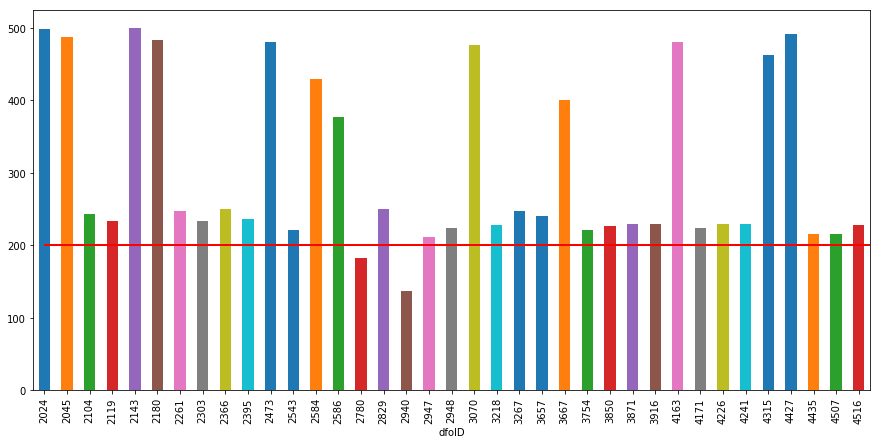

In [12]:
# Check the number of points for each flood
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['dfoID']).count()['score'].plot(ax=ax, kind='bar')
ax.hlines(y=200, xmin=0, xmax=64, linewidth=2, color='r')

In [13]:
df2 = df.groupby('dfoID').filter(lambda g: g.dfoID.count() > 200)
df2.dfoID.unique()

array([4171, 2143, 4427, 2024, 3657, 2948, 2045, 2366, 4315, 2543, 2586,
       2180, 2119, 2473, 2947, 2395, 2261, 3667, 3871, 2303, 2584, 4516,
       4163, 4241, 2829, 3916, 4435, 3850, 3070, 3754, 3267, 2104, 4226,
       4507, 3218])

### Export Master csv

In [14]:
df2.shape

(10885, 18)

In [ ]:
#%cd '/Users/ckuhn/Documents/Coauthor/GFD_Tellman/student_data/lumped_data/'
#df2.to_csv('all_student_data.csv', encoding='utf-8')

### Calculate matrix components

**Validation** = student classification  
** Strata** = DFO classification

- true positive = Validation (1) + Strata(4) = 5
- true negative = Validation (0) + Strata (0) =  0 
- false positive = Validation (0) + Strata (4) = 4
- false negative = Validation (1) + Strata (0) = 1

In [15]:
raw = df2.copy()
raw.shape

# The new 'score' column has values that will indicate tn, tp, fn, fp
raw['score'].value_counts()

5.0    4252
0.0    2558
3.0    2418
4.0    1268
2.0     309
1.0      80
Name: score, dtype: int64

In [16]:
y_act = raw['strata']
y_pred = raw['validation'] 
df_confusion = pd.crosstab(y_act, y_pred)
df_confusion

validation,0.0,1.0
strata,,
0,2558,80
2,309,2418
4,1268,4252


In [21]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 50)
    
set_style()  

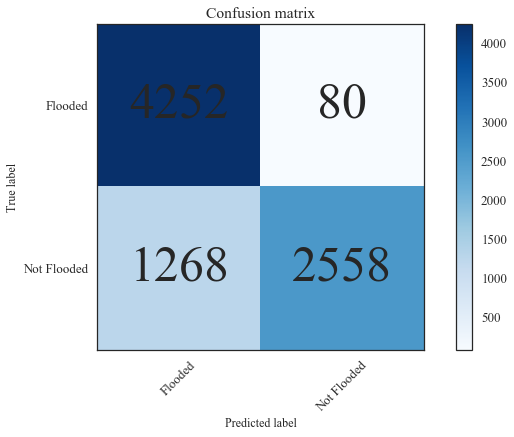

In [22]:
#Validation (1) + Strata (4)
tp = len(raw.loc[raw['score']== 5])
#Validation (0) + Strata (0)
tn = len(raw.loc[raw['score']== 0])
#Validation (0) + Strata (4)
fp = len(raw.loc[raw['score']== 4])
#Validation (1) + Strata (0)
fn = len(raw.loc[raw['score']== 1])


import numpy as np
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label',  fontsize=12)

    tp,
cm = np.array([[tp, fn],[fp, tn]])
plot_confusion_matrix(cm, ['Flooded', 'Not Flooded'])

In [24]:
total = tn+tp+fn+fp
print(tn/total) #32
print(tp/total) #52
print(fp/total) #15
print(fn/total) # <0.01


0.3135572444226526
0.5212061779848002
0.1554302525128708
0.009806325079676392


## Metrics by Events

In [26]:
floods = list(set(raw.dfoID)) ## Get a list of all the unique values of floods

In [27]:
floods = list(set(raw.dfoID)) ## Get a list of all the unique values of floods
sampling_levels = np.arange(0, 200, 1)

col_names =  ['Flood','NumofPoints', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood
my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

for i in floods:  ### Loop through floods
    df_full = raw.loc[raw['dfoID']== i] ### subset data frame by single flood
    for j in sampling_levels: ## Loop through sampling levels
        df = df_full.sample(j) ##Apparently pandas has a built-in dataframe random sampler!
        tp = float(len(df.loc[df['score']== 5])) 
        tn = float(len(df.loc[df['score']== 0]))
        fp = float(len(df.loc[df['score']== 4]))
        fn = float(len(df.loc[df['score']== 1]))
        ### Calculating values!
        if tp == 0: ###Hmm, sometimes there are no tp scores, so you get a zero divide error
            continue ###I've put this in for now but it's gonna bite your butt eventually
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
        accuracy = (tn + tp) / (tn+tp+fp+fn)
        commission = fp / (tp + fp)  # modeled positives over all true positives
        omission = fn / (tp + fn)
        ##add a new row to the dataframe based on this sampling level!
        my_df.loc[len(my_df)] = [i,j, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

        ###Now you should have a full dataframe with all your sampling levels for each flood
###SO
#my_df.to_csv('myprecious.csv', encoding='utf-8')

In [28]:
my_df.head()

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
0,4226.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,4226.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,4226.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,4226.0,4.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,4226.0,5.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [29]:
my_df = my_df.loc[my_df['NumofPoints'] == 199]
len(my_df)

35

In [30]:
my_df['Flood'] = my_df['Flood'].astype(int)
#my_df.to_csv('myprecious3.csv', encoding='utf-8')

In [31]:
print(len(my_df))
print(len(my_df.loc[my_df['overall_accuracy'] >= 0.9]))
print(len(my_df.loc[my_df['overall_accuracy'] >= 0.8]))
18/37 # 49% of the floods have 90% or better accuracy 
29/37 # 78% of the flood have 80% or better accuracy 
my_df['overall_accuracy'].describe()

# mean accuracy is 85%, median accuracy is 89%, 75% of the floods have 92% accuracy. 

35
16
23


count    35.000000
mean      0.836198
std       0.149547
min       0.359477
25%       0.771041
50%       0.862069
75%       0.947018
max       0.993506
Name: overall_accuracy, dtype: float64

In [32]:
my_df['omission'].mean()

0.02238782782112279

In [45]:
my_df['commission'].mean()

0.22182899539761314

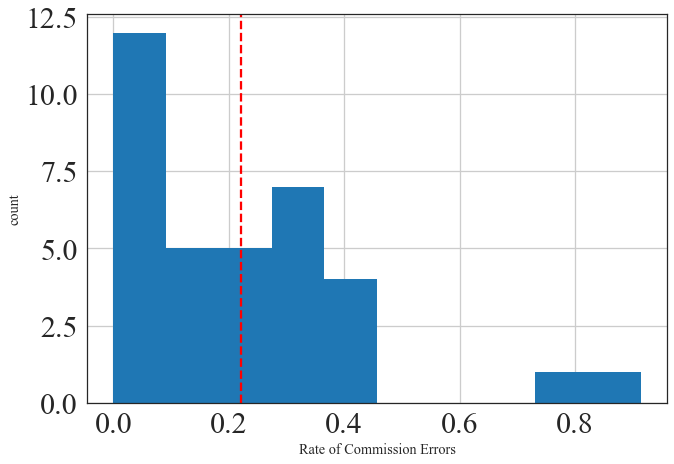

In [46]:
my_df['commission'].hist()
plt.ylabel('count')
plt.xlabel('Rate of Commission Errors')
plt.axvline(x=0.22182899539761314, color='red', ls='--')
# mean errors of commission is 22%, 

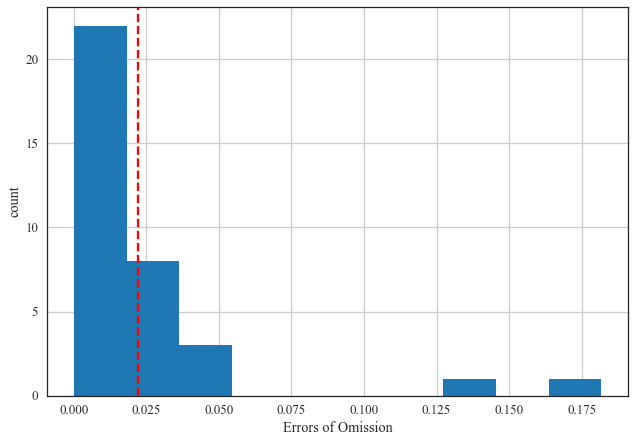

In [34]:
my_df['omission'].hist()
plt.ylabel('count')
plt.xlabel('Errors of Omission')
plt.axvline(x=0.022042942515367737, color='red', ls='--')

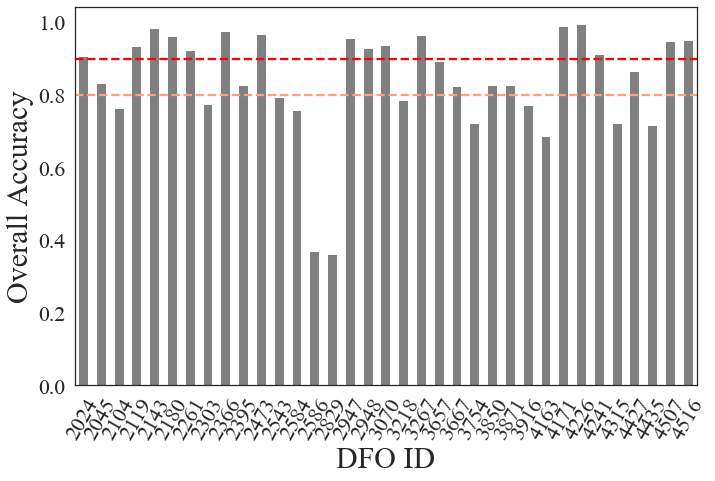

In [35]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 22)
    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22) 
set_style()  

my_df.groupby(['Flood'])['overall_accuracy'].mean().plot(kind='bar', color='grey')
plt.ylabel('Overall Accuracy', fontsize = 30)
plt.xlabel('DFO ID', fontsize = 30)
plt.axhline(y=0.9, color='red', ls='--')
plt.axhline(y=0.8, color='#FFA07A', ls='--')
plt.xticks(rotation=60)

plt.tight_layout()

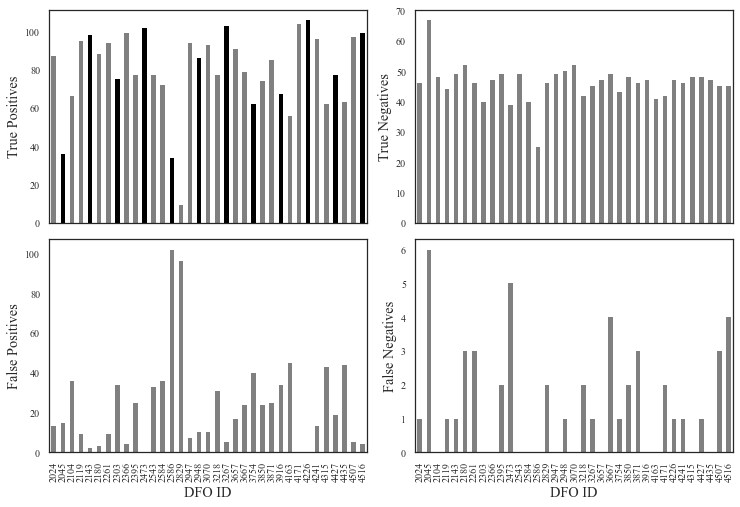

In [36]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 10)
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
set_style()  

plt.figure(figsize=(20, 12))


fig, ax = plt.subplots(2, 2)

my_df.groupby(['Flood'])['tp'].mean().plot(kind='bar', color = 
                                                              ['grey', 'black'], ax = ax[0,0])
ax[0, 0].set_ylabel('True Positives')
ax[0, 0].set_xlabel('')
#ax[0, 0].set_title('Depth (m)')
ax[0, 0].set_xticklabels([])

my_df.groupby(['Flood'])['tn'].mean().plot(kind='bar', color = 'grey', ax=ax[0, 1])
ax[0, 1].set_ylabel('True Negatives')
ax[0, 1].set_xlabel('')
#ax[0, 1].set_title('Turbidity (FNU)')
ax[0, 1].set_xticklabels([])

my_df.groupby(['Flood'])['fp'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 0])
ax[1, 0].set_ylabel('False Positives')
ax[1, 0].set_xlabel('DFO ID')
#ax[1, 0].set_title('Chlorophyll (RFU) ')

my_df.groupby(['Flood'])['fn'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 1])
ax[1, 1].set_ylabel('False Negatives')
ax[1, 1].set_xlabel('DFO ID')
#ax[1, 1].set_title('FDOM (rfu)')
#ax[1, 1].set_xticklabels(labels)

plt.tight_layout()

#%cd /Users/ckuhn/Documents/ABOVE/figures
#plt.savefig('FieldData_Barplots_BasicOptics.png', dpi = 300)

In [39]:
%cd '/Users/ckuhn/Documents/Coauthor/GFD_Tellman/student_data/lumped_data/'
test = pd.read_csv('myprecious2.csv', low_memory=False)
test.groupby(['Metric'])['Score'].mean()

/Users/ckuhn/Documents/Coauthor/GFD_Tellman/student_data/lumped_data


Metric
Commission           0.204723
False Negatives      1.432432
False Positives     14.594595
Omission             0.024559
Overall Accuracy     0.865561
Precision            0.795277
Recall               0.975441
True Negatives      47.567568
True Positives      54.243243
Name: Score, dtype: float64

In [40]:
error = test.loc[test['Metric'].isin(['Commission','Omission'])]
overall = test.loc[test['Metric'].isin(['Overall Accuracy','Precision','Recall' ])]
basics = test.loc[test['Metric'].isin(['True Positives','True Negatives','False Positives', 'False Negatives' ])]

In [41]:
# def set_style():
#     plt.style.use(['seaborn-white', 'seaborn-talk'])
#     plt.rc("font", family="Times New Roman", size = 24)
    
# set_style()    

# ax = sns.barplot(y="Score", x="Metric", palette= ['#388e3c', '#6abf69', '#00600f'],   data=overall)
# ax.set_ylabel('')
# ax.tick_params(labelsize=24)
# ax.set_title('')
# plt.tight_layout()
# plt.show()

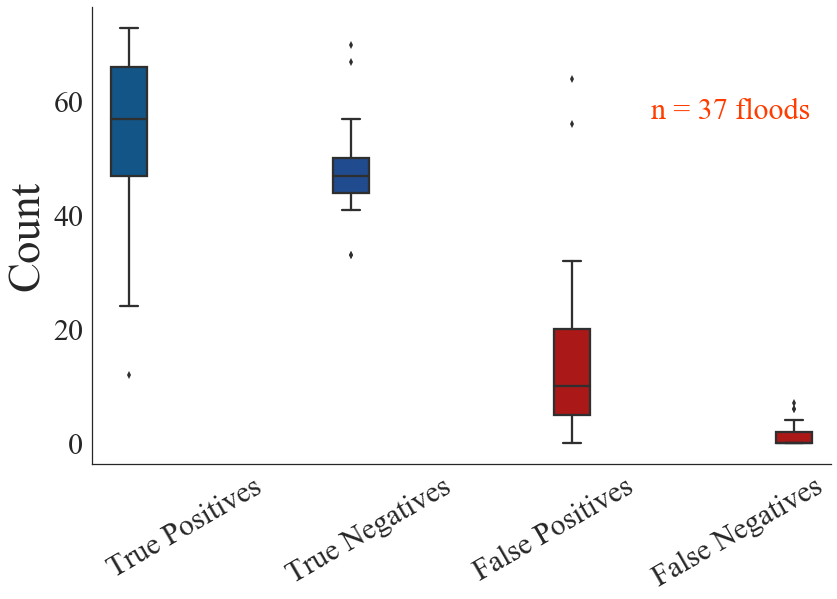

In [42]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  

order = 'True Positive', 'True Negative', 'False Negative', 'False Positive'

g = sns.factorplot(kind='box',        # Boxplot
               y='Score',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=basics,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#01579b', '#0d47a1', '#c30000', '#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.75, 0.75,'n = 37 floods', fontsize=30, color = '#ff3d00') #add text

g.set_xticklabels(rotation=30)

plt.ylabel('Count', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)


plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy/figures
#plt.savefig('GFD_basics.png', dpi = 300)

# http://queirozf.com/entries/matplotlib-pyplot-by-example#change-tick-label-rotation # ADD LABELS

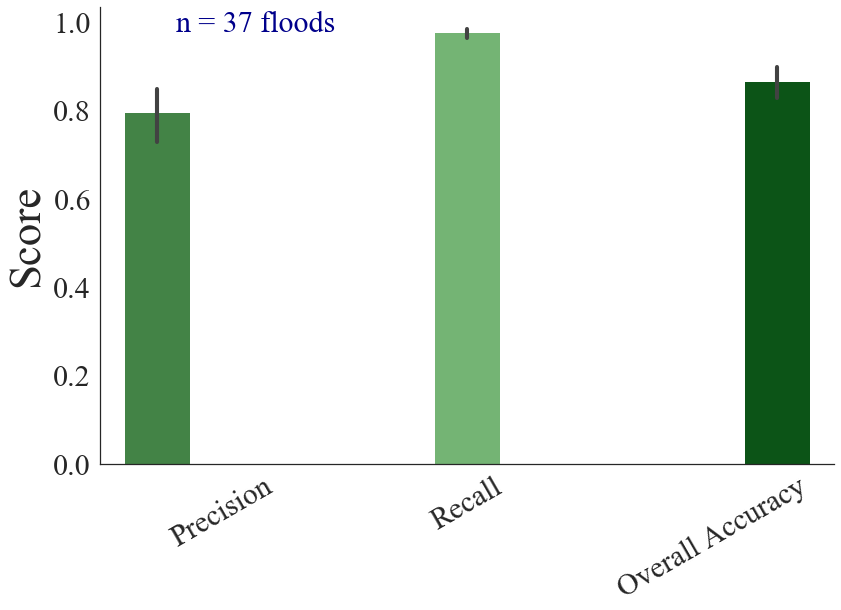

In [43]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  


g = sns.factorplot(kind='bar',        # Boxplot
               y='Score',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=overall,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#388e3c', '#6abf69', '#00600f'], 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.2, 0.90,'n = 37 floods', fontsize=30, color = 'darkblue') #add text
g.set_xticklabels(rotation=30)

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)


plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy/figures
#plt.savefig('GFD_basics.png', dpi = 300)

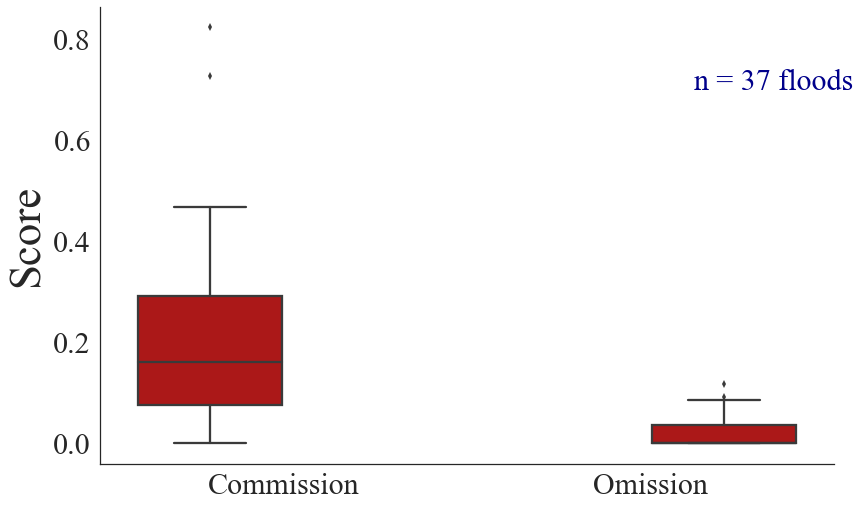

In [44]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  


g = sns.factorplot(kind='box',        # Boxplot
               y='Score',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=error,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= [ '#c30000','#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.8, 0.8,'n = 37 floods', fontsize=30, color = 'darkblue') #add text

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)

plt.show()

#%cd /Users/ckuhn/Documents/Coauthor/DFO_Accuracy/figures
#plt.savefig('GFD_error.png', dpi = 300)